<!--COURSE_INFORMATION-->
*This notebook contains material from [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by 
Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Charting Stock Data](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.03-Charting-Stock-Data.ipynb) | [Contents](index.ipynb) | [Real Options](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.05-Real-Options.ipynb) >
<p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.04-MAD-Portfolio-Optimization.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>


# MAD Portfolio Optimization

This notebook demonstrates portfolio optimization using the Mean Absolute Deviation (MAD) criterion. A portion of these notes is adapted from [GLPK Wikibook tutorial on the subject](http://en.wikibooks.org/wiki/GLPK/Portfolio_Optimization) written by me.

J.C. Kantor (Kantor.1@nd.edu)

In [0]:
%%capture
!pip install -q pyomo
!apt-get install -y -qq glpk-utils

!pip install ipywidgets

In [0]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

## Investment Objectives

* Maximize returns
* Reduce Risk through diversification

## Why Diversify?

Investment portfolios are collections of investments that are managed for overall investment return.  Compared to investing all of your capital into a single asset, maintaining a portfolio of investments allows you to manage risk through diversification.

### Reduce Risk through Law of Large Numbers

Suppose there are a set of independent investment opportunities that will pay back between 0 and 300% of your original investment, and that all outcomes in that range are equally likely. You have $100,000 to invest.  Should you put it all in one opportunity?  Or should you spread it around?

Here we simulate the outcomes of 1000 trials where we place all the money into a sigle investment of $100,000.

Average Profit = $49101


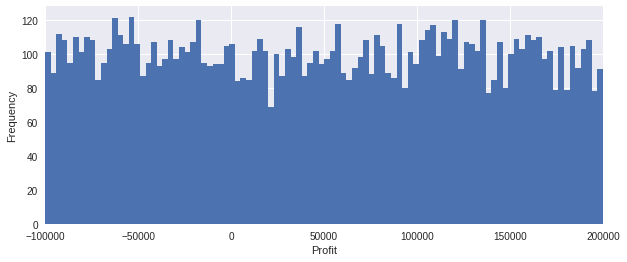

In [5]:
W0 = 100000.00

Ntrials = 10000
Profit = list()
for n in range(0, Ntrials):
    W1 = W0*random.uniform(0,3.00)
    Profit.append(W1 - W0)

plt.figure(figsize=(10,4))
plt.hist(Profit, bins=100)
plt.xlim(-100000, 200000)
plt.xlabel('Profit')
plt.ylabel('Frequency')

print('Average Profit = ${:.0f}'.format(np.mean(Profit)))

As you would expect, about 1/3 of the time there is a loss, and about 2/3 of the time there is a profit. In the extreme we can lose all of our invested capital. Is this an acceptable investment outcome?

Now let's see if what happens if we diversify our investment. We'll assume the investment outcomes have exactly the same probabilities. The only difference is that instead of one big investment of \$100,000, we'll break our capital into 5 smaller sized investments of \$20,000 each. We'll calculate the probability distribution of outcomes.

Average Profit = $50272


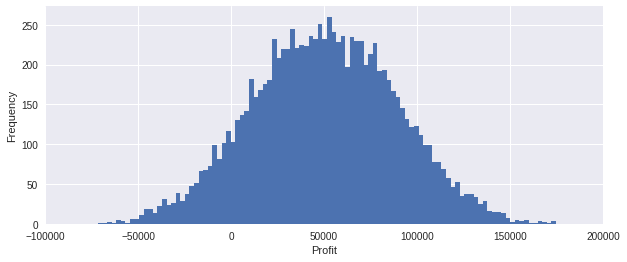

In [6]:
W0 = 100000.00

Ntrials = 10000
Ninvestments = 5

Profit = list()
for n in range(0,Ntrials):
    W1 = sum([(W0/Ninvestments)*random.uniform(0,3.00) for _ in range(0,Ninvestments)])
    Profit.append(W1-W0)

plt.figure(figsize=(10,4))
plt.hist(Profit, bins=100)
plt.xlim(-100000, 200000)
plt.xlabel('Profit')
plt.ylabel('Frequency')

print('Average Profit = ${:.0f}'.format(np.mean(Profit)))

What we observe is that even a small amount of diversification can dramatically reduce the downside risk of experiencing a loss. We also see the upside potential has been reduced. What hasn't changed is the that average profit remains at \$50,000. Whether or not the loss of upside potential in order to reduce downside risk is an acceptable tradeoff depends on your individual attitude towards risk. 

### Value at Risk (VaR)

[Value at risk (VaR)](https://en.wikipedia.org/wiki/Value_at_risk) is a measure of investment risk. Given a histogram of possible outcomes for the profit of a portfolio, VaR corresponds to negative value of the 5th percentile. That is, 5% of all outcomes would have a lower outcome, and 95% would have a larger outcome. 

The [conditional value at risk](https://en.wikipedia.org/wiki/Expected_shortfall) (also called the expected shortfall (ES), average value at risk (aVaR), and the expected tail loss (ETL)) is the negative of the average value of the lowest 5% of outcomes. 

The following cell provides an interactive demonstration. Use the slider to determine how to break up the total available capital into a number of smaller investments in order to reduce the value at risk to an acceptable (to you) level.  If you can accept only a 5% probability of a loss in your portfolio, how many individual investments would be needed?

Average Profit = $49560
Value at Risk (95%) = $797
Conditional Value at Risk (95%) = $13373


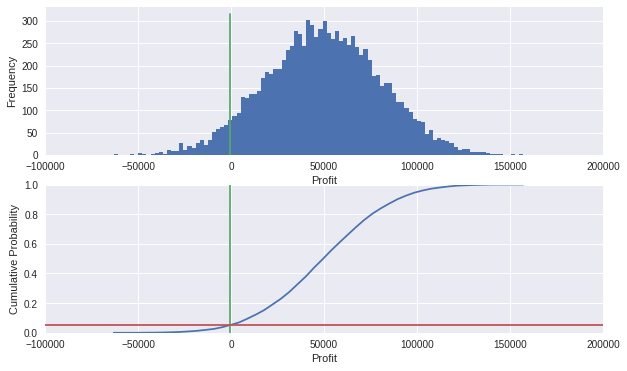

In [19]:
#@title Value at Risk (VaR) Demo { run: "auto", vertical-output: true }
Ninvestments = 8 #@param {type:"slider", min:1, max:20, step:1}

from statsmodels.distributions import ECDF

W0 = 100000.00
Ntrials = 10000

def sim(Ninvestments = 5):

    Profit = list()
    for n in range(0, Ntrials):
        W1 = sum([(W0/Ninvestments)*random.uniform(0,3.00) for _ in range(0,Ninvestments)])
        Profit.append(W1-W0)
        
    print('Average Profit = ${:.0f}'.format(np.mean(Profit)).replace('$-','-$'))

    VaR = -sorted(Profit)[int(0.05*Ntrials)]
    print('Value at Risk (95%) = ${:.0f}'.format(VaR).replace('$-','-$'))
    
    cVaR = -sum(sorted(Profit)[0:int(0.05*Ntrials)])/(0.05*Ntrials)
    print('Conditional Value at Risk (95%) = ${:.0f}'.format(cVaR).replace('$-','-$'))

    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.hist(Profit, bins=100)
    plt.xlim(-100000, 200000)
    plt.plot([-VaR, -VaR], plt.ylim())
    plt.xlabel('Profit')
    plt.ylabel('Frequency')

    plt.subplot(2,1,2)
    ecdf = ECDF(Profit)
    x = np.linspace(min(Profit), max(Profit))
    plt.plot(x,ecdf(x))
    plt.xlim(-100000, 200000)
    plt.ylim(0,1)
    plt.plot([-VaR, -VaR], plt.ylim())
    plt.plot(plt.xlim(), [0.05, 0.05])
    plt.xlabel('Profit')
    plt.ylabel('Cumulative Probability');
    
sim(Ninvestments)

## Import Historical Stock Price Data

In [24]:
!wget -N -q "https://raw.githubusercontent.com/jckantor/ND-Pyomo-Cookbook/master/notebooks/finance/Historical_Adjusted_Close.csv"
S_hist = pd.read_csv('/content/Historical_Adjusted_Close.csv', index_col=0)

S_hist.dropna(axis=1, how='any', inplace=True)
S_hist.index = pd.to_datetime(S_hist.index)
print(S_hist.columns)

portfolio = list(S_hist.columns)
S_hist.tail()

Index(['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'GE', 'GS', 'HD',
       'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
       'PFE', 'PG', 'T', 'TRV', 'UNH', 'UTX', 'VZ', 'WMT', 'XOM'],
      dtype='object')


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GE,GS,HD,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2018-05-30,187.5000,98.99,358.19,155.46,42.85,125.16,99.9800,14.17,229.16,187.09,...,72.0320,36.050,74.8900,32.5700,130.17,244.94,126.20,48.6000,84.1200,81.5000
2018-05-31,186.8700,98.30,352.16,151.91,42.71,124.30,99.4700,14.08,225.88,186.55,...,71.6032,35.930,73.1700,32.3200,128.52,241.51,124.82,47.6700,82.5400,81.2400
2018-06-01,190.2400,98.25,356.72,153.52,43.66,123.85,99.3600,14.10,228.35,187.35,...,72.7600,36.250,73.4500,32.4700,129.29,243.35,125.81,47.8100,82.9900,81.8300
2018-06-04,191.8300,99.45,360.73,152.50,43.58,122.26,100.2400,13.71,229.89,191.36,...,73.8300,36.450,74.1800,32.4100,129.72,244.63,126.29,47.8200,85.4200,80.9700
2018-06-05,192.8861,99.05,360.00,152.66,43.58,122.88,100.1144,13.85,228.90,191.05,...,74.1168,36.485,73.9755,32.4791,129.11,243.61,125.89,47.8601,84.4329,81.1126


## Select a Subperiod of the Historical Data

In [31]:
nYears = 1.5
start = S_hist.index[-int(nYears*252)]
end = S_hist.index[-1]

print('Start Date:', start)
print('  End Date:', end)

S = S_hist.loc[start:end]
S.head()

Start Date: 2016-12-02 00:00:00
  End Date: 2018-06-05 00:00:00


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GE,GS,HD,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2016-12-02,107.3034,70.2217,146.5851,91.4881,27.8083,106.6567,96.2544,29.8466,219.1815,125.5267,...,49.5074,29.8696,78.5432,35.7536,111.8143,157.8224,104.5824,46.3637,67.7871,82.1672
2016-12-05,106.5321,70.3879,146.4985,90.8246,28.0745,106.8926,97.6811,29.6276,224.2744,125.3430,...,50.8712,29.8318,79.1056,35.7721,112.0270,154.7785,103.8093,46.3078,66.8881,82.5826
2016-12-06,107.3522,70.6615,146.5755,91.5651,27.8844,106.4301,98.3651,29.6847,227.0515,124.4345,...,49.6154,29.8035,79.0293,36.4388,112.9552,154.4741,103.8189,46.8756,67.2898,82.6581
2016-12-07,108.4067,72.5963,148.4048,93.5941,28.4738,108.0158,99.6648,30.0942,231.1533,128.0300,...,51.1165,29.4541,80.2399,37.4574,114.7245,156.5165,105.9933,47.8250,67.9975,83.1396
2016-12-08,109.4709,73.2022,149.6083,92.5747,28.4738,108.7048,101.7853,30.0276,236.9331,128.0977,...,50.5769,29.2180,79.5917,37.4204,115.1037,156.4379,104.7853,47.5923,67.7471,83.3756


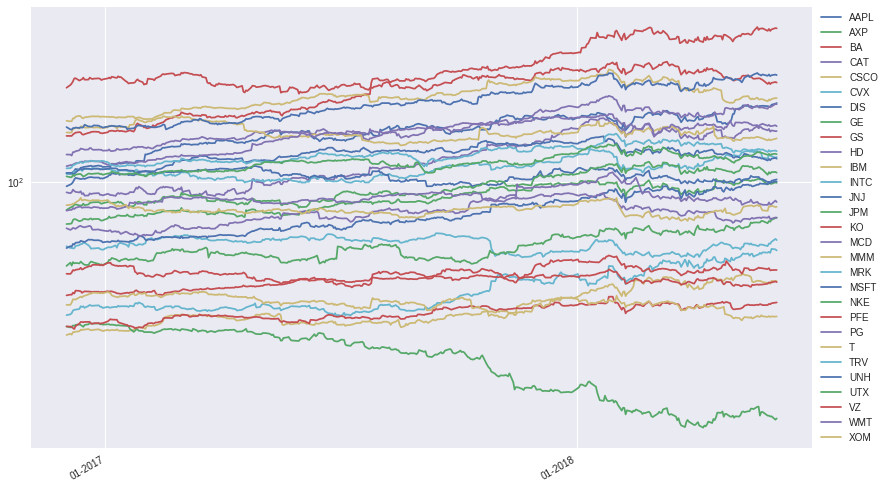

In [33]:
fig, ax = plt.subplots(figsize=(14,9))
S.plot(ax=ax, logy=True)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

## Return on a Portfolio

Given a portfolio with value $W_t$ at time $t$, return on the portfolio at $t_{t +\delta t}$ is defined as

\begin{align*}
r_{t + \delta t} & = \frac{W_{t + \delta t} - W_{t}}{W_{t}}
\end{align*}

For the period from $[t, t+\delta t)$ we assume there are $n_{j,t}$ shares of asset $j$ with a starting value of $S_{j,t}$ per share. The initial and final values of the portfolio are then 

\begin{align*}
W_t & = \sum_{j=1}^J n_{j,t}S_{j,t} \\
W_{t+\delta t} & = \sum_{j=1}^J n_{j,t}S_{j,t + \delta t}
\end{align*}

The return of the portfolio is given by

\begin{align*}
r_{t+\delta t} & = \frac{W_{t + \delta t} - W_{t}}{W_{t}} \\
& = \frac{\sum_{j=1}^Jn_{j,t}S_{j,t+\delta t} - \sum_{j=1}^J n_{j,t}S_{j,t}}{W_{t}} \\
& = \frac{\sum_{j=1}^J n_{j,t}S_{j,t}r_{j, t+\delta t}}{W_{t}} \\
& = \sum_{j=1}^J \frac{n_{j,t}S_{j,t}}{W_{t}} r_{j, t+\delta t}
\end{align*}

where $r_{j,t+\delta t}$ is the return on asset $j$ at time $t+\delta t$. 

Defining $W_{j,t} = n_{j,t}S_{j,t}$ as the wealth invested in asset $j$ at time $t$, then $w_{j,t} = n_{j,t}S_{j,t}/W_{t}$ is the fraction of total wealth invested in asset $j$ at time $t$. The portfolio return is then given by 

\begin{align*}
r_{t+\delta t} & = \sum_{j=1}^J w_{j,t} r_{j, t+\delta t} 
\end{align*}

on a single interval extending from $t$ to $t + \delta t$.

### Equally Weighted Portfolio

An equally weighted portfolio allocates an equal amount of capital to each component of the portfolio. The allocation can be done once and held fixed thereafter, or could be reallocated periodically as asset prices change in relation to one another.

#### Constant Fixed Allocation

If the initial allocation among $J$ assets takes place at $t=0$, then

$$w_{j,0} = \frac{1}{J} = \frac{n_{j,0} S_{j, t=0}}{W_{0}}$$

The number of assets of type $j$ included in the portfolio is given by

$$n_{j,0} = \frac{W_0}{J S_{j,0}} $$

which is then fixed for all later times $t > 0$. The value of the portfolio is given by

\begin{align*}
W_t & = \sum_{j=1}^J n_{j,0}S_{j,t} \\
& = \frac{W_{0}}{J} \sum_{j=1}^J \frac{S_{j,t}}{S_{j,0}}
\end{align*}

Note that this portfolio is guaranteed to be equally weighted only at $t=0$. Changes in the relative prices of assets cause the relative weights of assets in the portfolio to change over time.

#### Continually Rebalanced

Maitaining an equally weighted portfolio requires buying and selling of component assests as prices change relative to each other. To maintain an equally portfolio comprised of $J$ assets where the weights are constant in time,

\begin{align*}
w_{j,t} & = \frac{1}{J} = \frac{n_{j,t}S_{j,t}}{W_t} & \forall j, t
\end{align*}

Assuming the rebalancing occurs at fixed points in time $t_k$ separated by time steps $\delta t$, then on each half-closed interval $[t_k, t_k+\delta t)$

\begin{align*}
n_{j,t} & = \frac{W_{t_k}}{J S_{j,t_k}} \\
\end{align*}

The portfolio

\begin{align*}
W_{t_k + \delta t} & = \sum_{j=1}^J n_{j,t_k} S_{j, t_k + \delta t}
\end{align*}

\begin{align*}
W_{t_k + \delta t} & = W_{t_k} \sum_{j=1}^J  \frac{S_{j, t_k + \delta t}}{J S_{j,t_k}}
\end{align*}

Letting $t_{k+1} = t_k + \delta t$, then the following recursion describes the dynamics of an equally weighted,  continually rebalanced portfolio at the time steps $t_0, t_1, \ldots$. Starting with values $W_{t_0}$ and $S_{j, t_0}$, 

\begin{align*}
n_{j,t_k} & = \frac{W_{t_k}}{J S_{j,t_k}} \\
W_{t_{k+1}} & = \sum_{j=1}^J  n_{j,t_k} S_{j, t_{k+1}}
\end{align*}

which can be simulated as a single equation

\begin{align*}
W_{t_{k+1}} & = W_{t_k} \sum_{j=1}^J  \frac{S_{j, t_{k+1}}}{J S_{j,t_k}}
\end{align*}

or in closed-form

\begin{align*}
W_{t_{K}} & = W_{0} \prod_{k=0}^{K-1} \sum_{j=1}^J  \frac{S_{j, t_{k+1}}}{J S_{j,t_k}}
\end{align*}

Text(0.5,1,'Value of an equally weighted portfolio')

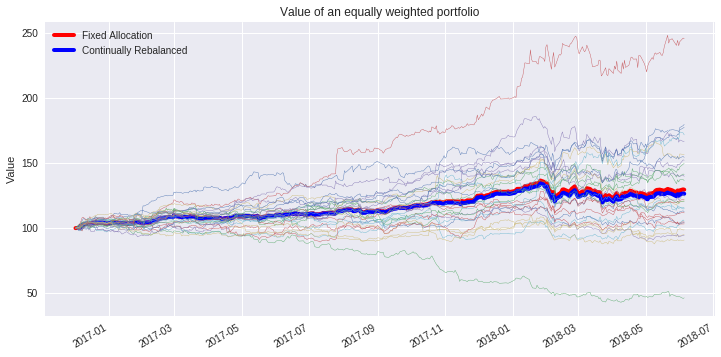

In [49]:
plt.figure(figsize=(12,6))

portfolio = S.columns
J = len(portfolio)

# equal weight with no rebalancing
n = 100.0/S.iloc[0]/J
W_fixed = sum(n[s]*S[s] for s in portfolio)
W_fixed.plot(color='r',lw=4)

# equal weighting with continual rebalancing
#W_rebal = [100]
#for k in range(1, len(S.index)):
#    n = W_rebal[k-1]/S.iloc[k-1,:]/len(portfolio)
#    W_rebal.append(sum(n[j]*S.iloc[k,j] for j in range(0, len(portfolio))))
    
#W_rebal = pd.Series(W_rebal, index=S.index)
#W_rebal.plot(lw=4, color='b')

# equal weighting with continual rebalancing
R = (S[1:]/S.shift(1)[1:]).sum(axis=1)/len(portfolio)
W_rebal = 100*R.cumprod()
W_rebal.plot(color='b', lw=4)

# individual assets
for s in portfolio:
    (100.0*S[s]/S[s][0]).plot(lw=0.4)
    
plt.legend(['Fixed Allocation','Continually Rebalanced'])

plt.ylabel('Value');
plt.title('Value of an equally weighted portfolio')

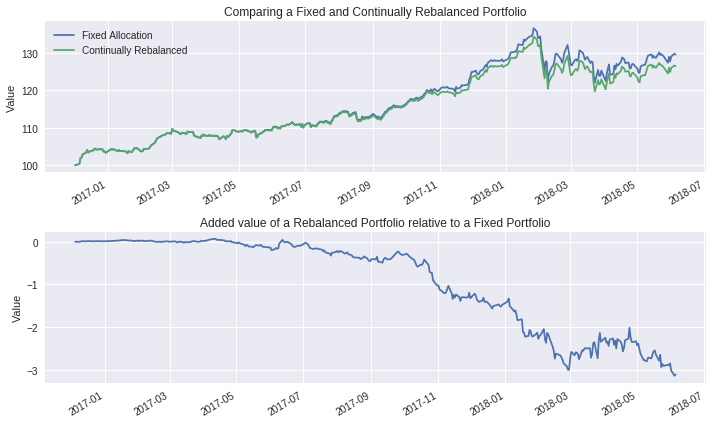

In [50]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
W_fixed.plot()
W_rebal.plot()
plt.legend(['Fixed Allocation','Continually Rebalanced'])
plt.ylabel('Value')
plt.title('Comparing a Fixed and Continually Rebalanced Portfolio')

plt.subplot(2,1,2)
(W_rebal-W_fixed).plot()
plt.title('Added value of a Rebalanced Portfolio relative to a Fixed Portfolio')
plt.ylabel('Value')

plt.tight_layout()

### Component Returns

Given data on the prices for a set of assets over an historical period $t_0, t_1, \ldots, t_K$, an estimate the mean arithmetic return is given by the mean value

\begin{align*}
\hat{r}_{j,t_K} & = \frac{1}{K}\sum_{k=1}^{K} r_{t_k} \\
& = \sum_{k=1}^{K} \frac{S_{j,t_{k}}-S_{j,t_{k-1}}}{S_{j,t_{k-1}}}
\end{align*}

At any point in time, $t_k$, a mean return can be computed using the previous $H$ intervals

\begin{align*}
\hat{r}^H_{j,t_k} & = \frac{1}{H}\sum_{h=0}^{H-1} r_{t_{k-h}} \\
& = \frac{1}{H} \sum_{h=0}^{H-1}\frac{S_{j,t_{k-h}} - S_{j,t_{k-h-1}}}{S_{j,t_{k-h-1}}}
\end{align*}

Arithmetic returns are computed so that subsequent calculations combine returns across components of a portfolio.



## Measuring Deviation in Component Returns

### Standard Deviation

### Mean Absolute Deviation

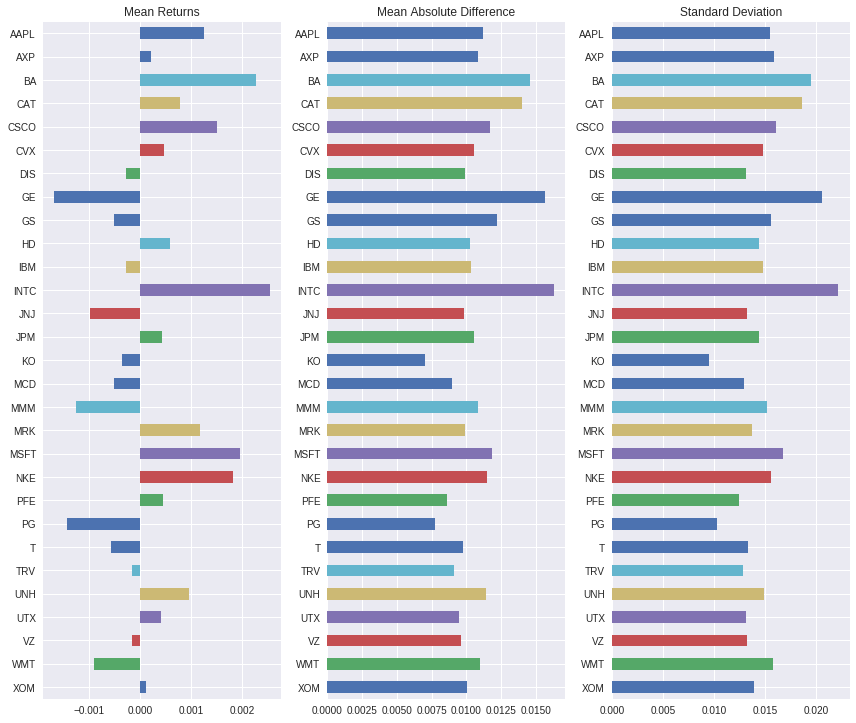

In [51]:
def roll(H):
    k = len(S.index)
    R = S[k-H-1:k].diff()[1:]/S[k-H-1:k].shift(1)[1:]
    AD = abs(R - R.mean())
    
    plt.figure(figsize = (12, 0.35*len(R.columns)))
    idx = R.columns.argsort()[::-1]

    plt.subplot(1,3,1)
    R.mean().iloc[idx].plot(kind='barh')
    plt.title('Mean Returns');

    plt.subplot(1,3,2)
    AD.mean().iloc[idx].plot(kind='barh')
    plt.title('Mean Absolute Difference')

    plt.subplot(1,3,3)
    R.std().iloc[idx].plot(kind='barh')
    plt.title('Standard Deviation')

    plt.tight_layout()

roll(500)

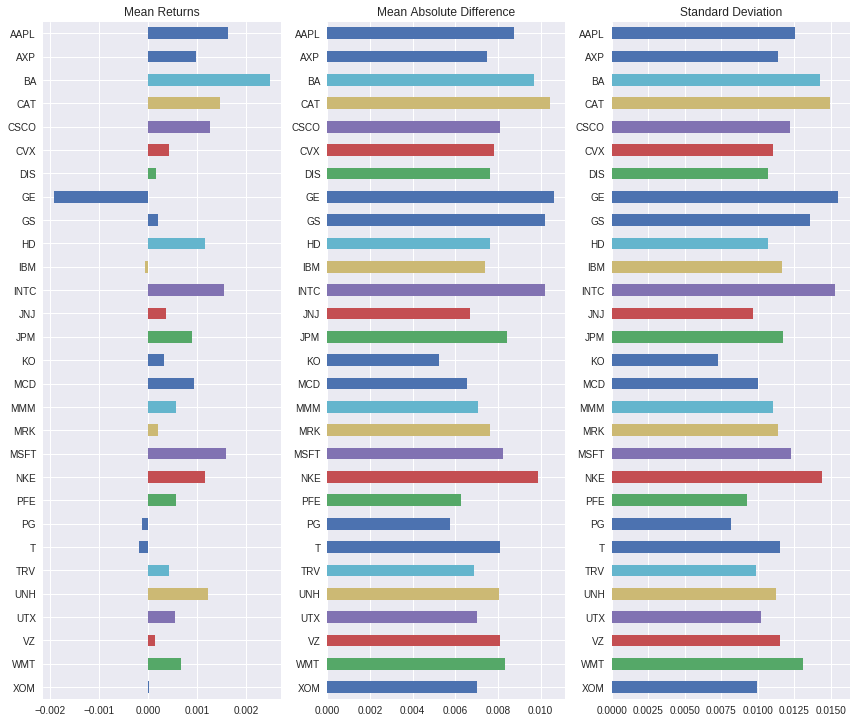

In [52]:
R = (S.diff()[1:]/S.shift(1)[1:]).dropna(axis=0, how='all')
AD = abs(R - R.mean())

plt.figure(figsize = (12, 0.35*len(R.columns)))
idx = R.columns.argsort()[::-1]

plt.subplot(1,3,1)
R.mean().iloc[idx].plot(kind='barh')
plt.title('Mean Returns');

plt.subplot(1,3,2)
AD.mean().iloc[idx].plot(kind='barh')
plt.title('Mean Absolute Difference')

plt.subplot(1,3,3)
R.std().iloc[idx].plot(kind='barh')
plt.title('Standard Deviation')

plt.tight_layout()

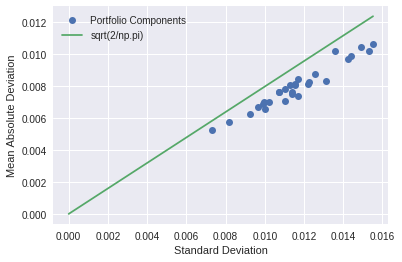

In [53]:
plt.plot(R.std(), AD.mean(), 'o')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean Absolute Deviation')

plt.plot([0,R.std().max()],[0,np.sqrt(2.0/np.pi)*R.std().max()])
plt.legend(['Portfolio Components','sqrt(2/np.pi)'],loc='best');

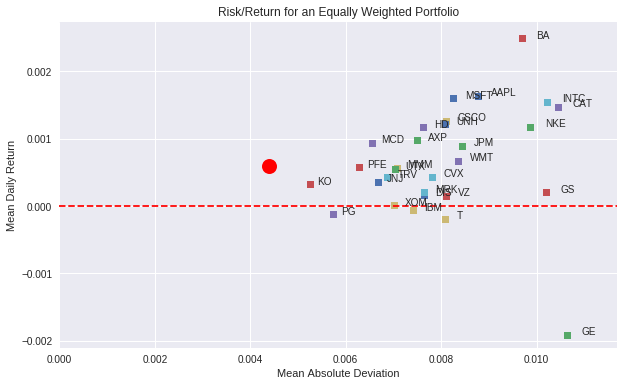

In [69]:
plt.figure(figsize=(10,6))
for s in portfolio:
    plt.plot(AD[s].mean(), R[s].mean(),'s')
    plt.text(AD[s].mean()*1.03, R[s].mean(), s)
    
R_equal = W_rebal.diff()[1:]/W_rebal[1:]
#R_equal = np.log(W_rebal/W_rebal.shift(+1))
M_equal = abs(R_equal-R_equal.mean()).mean()

plt.plot(M_equal, R_equal.mean(), 'ro', ms=15)

plt.xlim(0, 1.1*max(AD.mean()))
plt.ylim(min(0, 1.1*min(R.mean())), 1.1*max(R.mean()))
plt.plot(plt.xlim(),[0,0],'r--');
plt.title('Risk/Return for an Equally Weighted Portfolio')
plt.xlabel('Mean Absolute Deviation')
plt.ylabel('Mean Daily Return');


## MAD Porfolio

The linear program is formulated and solved using the pulp package. 

In [70]:
R.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GE,GS,HD,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2016-12-05,-0.007188,0.002367,-0.000591,-0.007252,0.009573,0.002212,0.014822,-0.007338,0.023236,-0.001463,...,0.027547,-0.001266,0.007160,0.000517,0.001902,-0.019287,-0.007392,-0.001206,-0.013262,0.005056
2016-12-06,0.007698,0.003887,0.000526,0.008153,-0.006771,-0.004327,0.007002,0.001927,0.012383,-0.007248,...,-0.024686,-0.000949,-0.000965,0.018637,0.008286,-0.001967,0.000092,0.012261,0.006006,0.000914
2016-12-07,0.009823,0.027381,0.012480,0.022159,0.021137,0.014899,0.013213,0.013795,0.018066,0.028895,...,0.030255,-0.011723,0.015318,0.027954,0.015664,0.013222,0.020944,0.020254,0.010517,0.005825
2016-12-08,0.009817,0.008346,0.008110,-0.010892,0.000000,0.006379,0.021276,-0.002213,0.025004,0.000529,...,-0.010556,-0.008016,-0.008078,-0.000988,0.003305,-0.000502,-0.011397,-0.004866,-0.003682,0.002839
2016-12-09,0.016322,-0.001869,0.007079,-0.007686,0.003674,0.005557,0.014316,0.007929,0.001657,0.006489,...,0.003298,0.024564,0.010419,-0.000743,0.006843,0.005022,0.012543,0.007041,-0.003696,0.007699


The decision variables will be indexed by date/time.  The pandas dataframes containing the returns data are indexed by timestamps that include characters that cannot be used by the GLPK solver. Therefore we create a dictionary to translate the pandas timestamps to strings that can be read as members of a GLPK set. The strings denote seconds in the current epoch as defined by python.

In [71]:
a = R - R.mean()
a.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GE,GS,HD,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2016-12-05,-0.008823,0.001389,-0.003078,-0.008722,0.008305,0.001775,0.014661,-0.005425,0.023029,-0.002636,...,0.026374,-0.001839,0.007286,0.000706,0.001472,-0.020502,-0.007936,-0.001356,-0.013931,0.005040
2016-12-06,0.006063,0.002910,-0.001961,0.006683,-0.008038,-0.004763,0.006841,0.003840,0.012176,-0.008420,...,-0.025859,-0.001522,-0.000839,0.018826,0.007855,-0.003182,-0.000452,0.012111,0.005337,0.000899
2016-12-07,0.008188,0.026404,0.009993,0.020689,0.019870,0.014462,0.013051,0.015708,0.017858,0.027722,...,0.029081,-0.012297,0.015444,0.028142,0.015233,0.012006,0.020400,0.020103,0.009848,0.005810
2016-12-08,0.008182,0.007369,0.005623,-0.012362,-0.001267,0.005942,0.021115,-0.000300,0.024797,-0.000643,...,-0.011730,-0.008589,-0.007953,-0.000800,0.002875,-0.001718,-0.011941,-0.005016,-0.004351,0.002823
2016-12-09,0.014687,-0.002846,0.004592,-0.009156,0.002406,0.005121,0.014155,0.009842,0.001450,0.005317,...,0.002125,0.023990,0.010545,-0.000555,0.006412,0.003806,0.011999,0.006890,-0.004365,0.007683


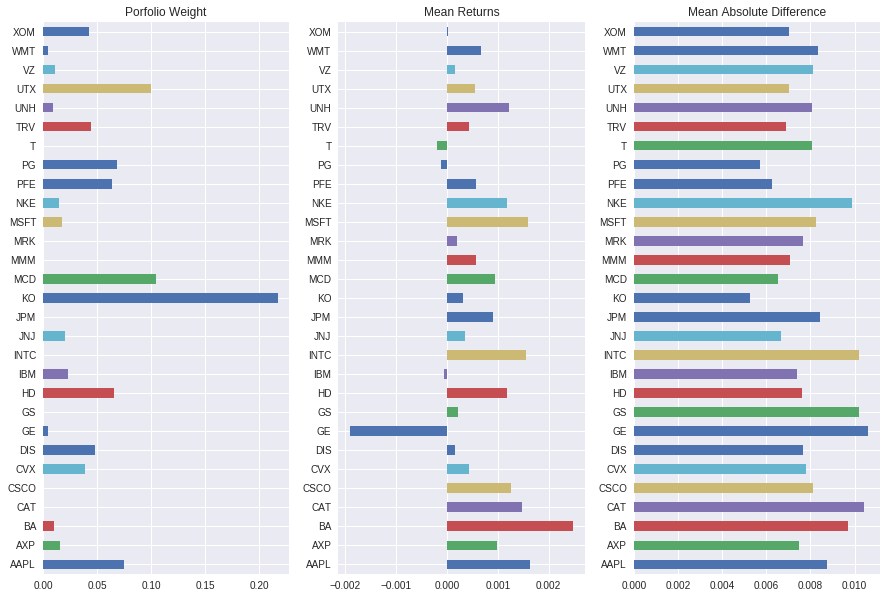

In [72]:
from pyomo.environ import *

a = R - R.mean()

m = ConcreteModel()

m.w = Var(R.columns, domain=NonNegativeReals)
m.y = Var(R.index, domain=NonNegativeReals)

m.MAD = Objective(expr=sum(m.y[t] for t in R.index)/len(R.index), sense=minimize)

m.c1 = Constraint(R.index, rule = lambda m, t:
    m.y[t] + sum(a.loc[t,s]*m.w[s] for s in R.columns) >= 0)

m.c2 = Constraint(R.index, rule = lambda m, t:
    m.y[t] - sum(a.loc[t,s]*m.w[s] for s in R.columns) >= 0)

m.c3 = Constraint(expr=sum(R[s].mean()*m.w[s] for s in R.columns) >= R_equal.mean())

m.c4 = Constraint(expr=sum(m.w[s] for s in R.columns)==1)

SolverFactory('glpk').solve(m)

w = {s: m.w[s]() for s in R.columns}

plt.figure(figsize = (15,0.35*len(R.columns)))

plt.subplot(1,3,1)
pd.Series(w).plot(kind='barh')
plt.title('Porfolio Weight');

plt.subplot(1,3,2)
R.mean().plot(kind='barh')
plt.title('Mean Returns');

plt.subplot(1,3,3)
AD.mean().plot(kind='barh')
plt.title('Mean Absolute Difference');

Text(0,0.5,'Unit Value')

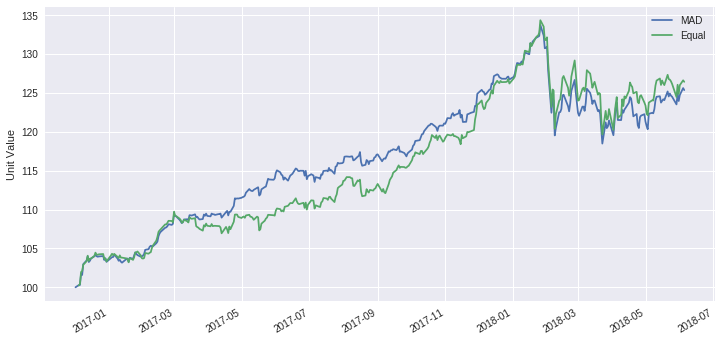

In [76]:
P_mad = pd.Series(0,index=S.index)
for s in portfolio:
    P_mad += 100.0*w[s]*S[s]/S[s][0]
    
plt.figure(figsize=(12,6))
P_mad.plot()
W_rebal.plot()
plt.legend(['MAD','Equal'],loc='best')
plt.ylabel('Unit Value')

Text(0,0.5,'Mean Daily Return')

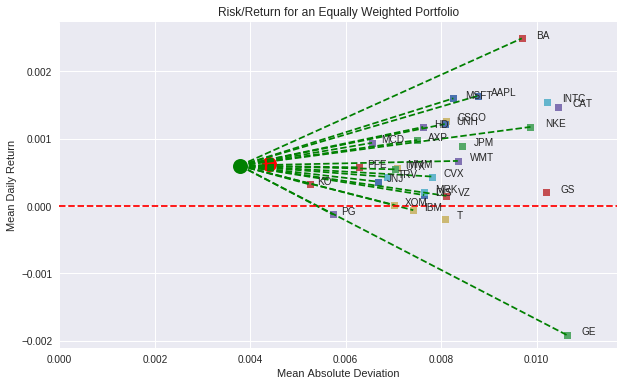

In [80]:
plt.figure(figsize=(10,6))
for s in portfolio:
    plt.plot(AD[s].mean(), R[s].mean(),'s')
    plt.text(AD[s].mean()*1.03, R[s].mean(), s)
    
#R_equal = P_equal.diff()[1:]/P_equal[1:]
R_equal = np.log(W_rebal/W_rebal.shift(+1))
M_equal = abs(R_equal-R_equal.mean()).mean()

plt.plot(M_equal, R_equal.mean(), 'ro', ms=15)

#R_mad = P_mad.diff()[1:]/P_mad[1:]
R_mad = np.log(P_mad/P_mad.shift(+1))
M_mad = abs(R_mad-R_mad.mean()).mean()

plt.plot(M_mad, R_mad.mean(), 'go', ms=15)

for s in portfolio:
    if w[s] >= 0.0001:
        plt.plot([M_mad, AD[s].mean()],[R_mad.mean(), R[s].mean()],'g--')
    if w[s] <= -0.0001:
        plt.plot([M_mad, AD[s].mean()],[R_mad.mean(), R[s].mean()],'r--')

plt.xlim(0, 1.1*max(AD.mean()))
plt.ylim(min(0, 1.1*min(R.mean())), 1.1*max(R.mean()))
plt.plot(plt.xlim(),[0,0],'r--');
plt.title('Risk/Return for an Equally Weighted Portfolio')
plt.xlabel('Mean Absolute Deviation')
plt.ylabel('Mean Daily Return')

In [0]:


import pulp

# mean absolute deviation for the portfolio
m = pulp.LpVariable('m', lowBound = 0)

# dictionary of portfolio weights
w = pulp.LpVariable.dicts('w', portfolio, lowBound = 0)

# dictionary of absolute deviations of portfolio returns
y = pulp.LpVariable.dicts('y', t.values(), lowBound = 0)
z = pulp.LpVariable.dicts('z', t.values(), lowBound = 0)

# create problem instance
lp = pulp.LpProblem('MAD Portfolio',pulp.LpMinimize)

# add objective
lp += m

# calculate mean absolute deviation of portfolio returns
lp += m == pulp.lpSum([(y[k] + z[k]) for k in t.values()])/float(len(t))

# relate the absolute deviations to deviations in the portfolio returns
for ts in returns.index:
    lp += y[t[ts]] - z[t[ts]] == pulp.lpSum([w[s]*(returns[s][ts]-returns[s].mean()) for s in portfolio]) 
    
# portfolio weights
lp += pulp.lpSum([w[s] for s in portfolio]) == 1.0

# bound on average portfolio return
lp += pulp.lpSum([w[s]*(returns[s].mean()) for s in portfolio]) >= 0*R_equal.mean()

lp.solve()
print pulp.LpStatus[lp.status]

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(pulp.LpStatus[lp.status])? (<ipython-input-164-77bf056feb2a>, line 35)

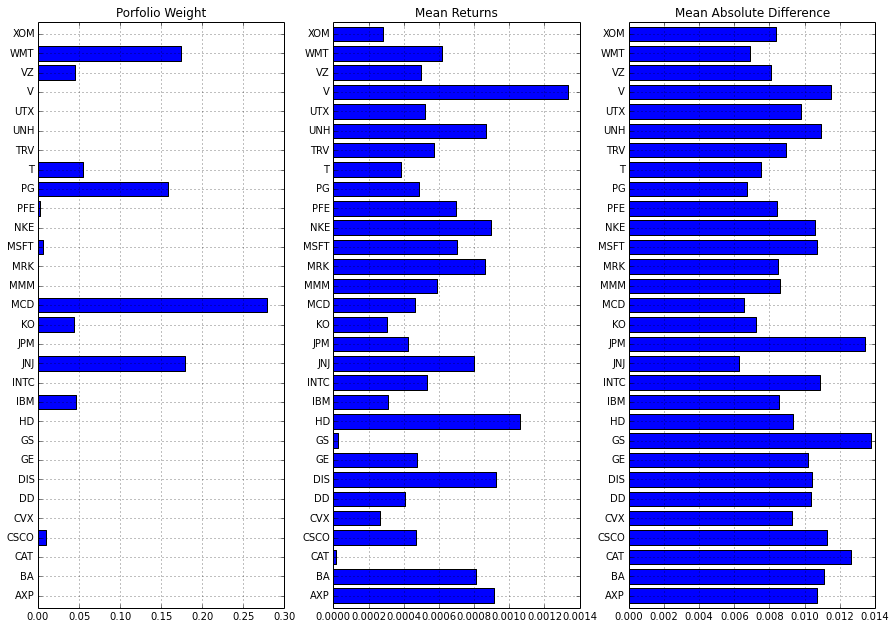

In [0]:
figure(figsize = (15,0.35*len(returns.columns)))

ws = pd.Series({s: w[s].varValue for s in portfolio},index=portfolio)

subplot(1,3,1)
ws.plot(kind='barh')
title('Porfolio Weight');

subplot(1,3,2)
returns.mean().plot(kind='barh')
title('Mean Returns');

subplot(1,3,3)
abs(returns-returns.mean()).mean().plot(kind='barh')
title('Mean Absolute Difference');

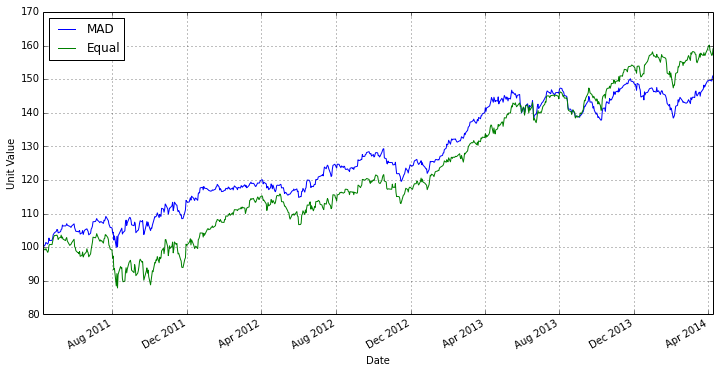

In [0]:
P_mad = pd.Series(0,index=adjclose.index)
for s in portfolio:
    P_mad += 100.0*ws[s]*adjclose[s]/adjclose[s][0]
    
figure(figsize=(12,6))
P_mad.plot()
P_equal.plot()
legend(['MAD','Equal'],loc='best')
ylabel('Unit Value')

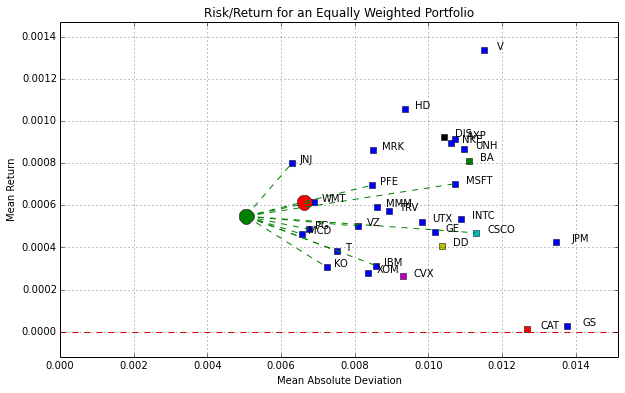

In [0]:
figure(figsize=(10,6))
for s in portfolio:
    plot(mad[s],rmean[s],'s')
    text(mad[s]*1.03,rmean[s],s)
    
axis([0, 1.1*max(mad), min([0,min(rmean)-.1*(max(rmean)-min(rmean))]), 1.1*max(rmean)])
ax = axis()
plot([ax[0],ax[1]],[0,0],'r--');

#R_equal = P_equal.diff()[1:]/P_equal[1:]
R_equal = log(P_equal/P_equal.shift(+1))
M_equal = abs(R_equal-R_equal.mean()).mean()

plot(M_equal,R_equal.mean(),'ro',ms=15)

#R_mad = P_mad.diff()[1:]/P_mad[1:]
R_mad = log(P_mad/P_mad.shift(+1))
M_mad = abs(R_mad-R_mad.mean()).mean()

for s in portfolio:
    if ws[s] >= 0.0001:
        plot([M_mad,mad[s]],[R_mad.mean(),rmean[s]],'g--')

plot(M_mad,R_mad.mean(),'go',ms=15)

title('Risk/Return for an Equally Weighted Portfolio')
xlabel('Mean Absolute Deviation')
ylabel('Mean Return')

grid();

## Problem 1: Solve for Dominating MAD Portfolio

In [0]:
lp = pulp.LpProblem('MAD Portfolio',pulp.LpMinimize)
lp += m    
lp += m == pulp.lpSum([(y[t] + z[t])/float(len(returns.index)) for t in tmap.values()])
lp += pulp.lpSum([w[s] for s in symbols]) == 1.0

for t in returns.index:
    lp += y[tsec[t]] - z[tsec[t]] == pulp.lpSum([w[s]*(returns[s][t]-rmean[s]) for s in symbols]) 
        
lp.solve()
m_min = m.varValue
m_min

NameError: name 'tmap' is not defined

In [0]:
# Solve for maximum return at minimum MAD

r = pulp.LpVariable('r',lowBound = 0)

lp = pulp.LpProblem('MAD Portfolio',pulp.LpMaximize)
lp += r
lp += r == pulp.lpSum([w[s]*rmean[s] for s in symbols])
lp += m_min == pulp.lpSum([(y[t] + z[t])/float(len(returns.index)) for t in tmap.values()])
lp += pulp.lpSum([w[s] for s in symbols]) == 1.0
for t in returns.index:
    lp += y[tsec[t]] - z[tsec[t]] == pulp.lpSum([w[s]*(returns[s][t]-rmean[s]) for s in symbols]) 
        
lp.solve()
r_min = r.varValue
w_min = pd.Series([pulp.value(w[s]) for s in symbols], index= symbols)

NameError: name 'symbols' is not defined

<!--NAVIGATION-->
< [Charting Stock Data](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.03-Charting-Stock-Data.ipynb) | [Contents](index.ipynb) | [Real Options](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.05-Real-Options.ipynb) >
<p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.04-MAD-Portfolio-Optimization.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>
